# Implementierung eines SNN und CNN: Ein Vergleich mit dem Kanji-Datensatz


*Author: Ümmühan Ay*

Schritt 1: Alle nötigen Imports importieren

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

Schritt 2: Cuda benutzen

In [2]:
device = torch.device("cuda")

Schritt 3: Implementierung des SNN und des LIF

In [3]:
class SurrogateSpike(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return (input > 0).float()

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        surrogate_grad = torch.exp(-input.abs())  # Glatte Ableitung
        return grad_output * surrogate_grad

spike_fn = SurrogateSpike.apply

In [4]:
class SNN(nn.Module):
     def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size,
                 v_rest=-65.0, v_thresh=-50.0, v_reset=-65.0, tau_mem=10.0):
        super(SNN, self).__init__()
        self.v_rest = v_rest
        self.v_thresh = v_thresh
        self.v_reset = v_reset
        self.tau_mem = tau_mem

        # Synaptische Gewichte
        self.synapse1 = nn.Parameter(torch.randn(input_size, hidden_size1) * 0.1)
        self.synapse2 = nn.Parameter(torch.randn(hidden_size1, hidden_size2) * 0.1)
        self.synapse3 = nn.Parameter(torch.randn(hidden_size2, hidden_size3) * 0.1)
        self.fc_out = nn.Linear(hidden_size3, output_size)

        # BatchNorm für Stabilisierung
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.bn3 = nn.BatchNorm1d(hidden_size3)

     def forward(self, x, dt=1e-3):
        batch_size, time_steps, _ = x.shape

        # Initialisiere Membranpotenziale
        v1 = torch.full((batch_size, self.synapse1.shape[1]), self.v_rest, device=x.device)
        v2 = torch.full((batch_size, self.synapse2.shape[1]), self.v_rest, device=x.device)
        v3 = torch.full((batch_size, self.synapse3.shape[1]), self.v_rest, device=x.device)

        spikes1 = torch.zeros(batch_size, time_steps, self.synapse1.shape[1], device=x.device)
        spikes2 = torch.zeros(batch_size, time_steps, self.synapse2.shape[1], device=x.device)
        spikes3 = torch.zeros(batch_size, time_steps, self.synapse3.shape[1], device=x.device)

        for t in range(time_steps):
            z0 = x[:, t, :]  # Input

            v1 += (self.v_rest - v1) * (dt / self.tau_mem) + torch.matmul(z0, self.synapse1)
            z1 = spike_fn(v1 - self.v_thresh)
            v1 = torch.where(z1 > 0, torch.tensor(self.v_reset, device=x.device), v1)
            spikes1[:, t, :] = z1

            v2 += (self.v_rest - v2) * (dt / self.tau_mem) + torch.matmul(z1, self.synapse2)
            z2 = spike_fn(v2 - self.v_thresh)
            v2 = torch.where(z2 > 0, torch.tensor(self.v_reset, device=x.device), v2)
            spikes2[:, t, :] = z2

            v3 += (self.v_rest - v3) * (dt / self.tau_mem) + torch.matmul(z2, self.synapse3)
            z3 = spike_fn(v3 - self.v_thresh)
            v3 = torch.where(z3 > 0, torch.tensor(self.v_reset, device=x.device), v3)
            spikes3[:, t, :] = z3

        # Summe der Spikes → Klassifizierung
        summed = spikes3.sum(dim=1)
        summed = self.bn3(summed)
        output = self.fc_out(summed)
        return output

Schritt 4: MNIST-Datensatz laden

Test mit Kanji-Datensatz

In [5]:
from torch.utils.data import Subset

train_data = np.load('kmnist-train-imgs.npz')['arr_0']  # 60,000 Bilder
train_labels = np.load('kmnist-train-labels.npz')['arr_0']  # 60,000 Labels

test_data = np.load('kmnist-test-imgs.npz')['arr_0']  # 10,000 Bilder
test_labels = np.load('kmnist-test-labels.npz')['arr_0']  # 10,000 Labels

class KuzushijiMNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return torch.tensor(image, dtype=torch.float32), torch.tensor(label, dtype=torch.long)
    

transform = transforms.Compose([transforms.ToTensor()])

train_dataset = KuzushijiMNISTDataset(train_data, train_labels, transform=transform)
test_dataset = KuzushijiMNISTDataset(test_data, test_labels, transform=transform)

#train_subset = Subset(train_dataset, range(9000))
#test_subset = Subset(test_dataset, range(1000))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

def image_to_spikes(images, time_steps, threshold=0.0):
    images = images.view(images.size(0), -1)  # (B, 3072)
    spikes = torch.zeros((images.size(0), time_steps, images.size(1)), device=images.device)
    for t in range(time_steps):
        spikes[:, t, :] = (images > threshold).float()
    return spikes

Schritt 5: CNN erstellen

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  # 1 Kanal (nicht 3!)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        
        # Feature Map-Größe nach 3x Pooling mit Kernel 2: 28 → 14 → 7 → 3 (eigentlich 3x3)
        self.fc1 = nn.Linear(64 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 10)

        self.dropout = nn.Dropout(0.5)

        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # 28x28 → 14x14
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # 14x14 → 7x7
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # 7x7 → 3x3

        x = x.view(x.size(0), -1)  # Flatten: 64 * 3 * 3
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

6. Hyperparameter, Loss-Funktion und Optimizer definieren

In [7]:
# Hyperparameter
input_size = 28 * 28
hidden_size1 = 512
hidden_size2 = 512
hidden_size3 = 512
output_size = 10
epochs = 10
time_steps = 50

snn_model = SNN(
    input_size=input_size,
    hidden_size1=hidden_size1,
    hidden_size2=hidden_size2,
    hidden_size3=hidden_size3,
    output_size=output_size
).to(device)
cnn_model = SimpleCNN().to(device)

snn_optimizer = torch.optim.Adam(snn_model.parameters(), lr=0.05)
cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)

snn_loss_fn = torch.nn.CrossEntropyLoss()
cnn_loss_fn = torch.nn.CrossEntropyLoss()

In [8]:
import time

start = time.time()

torch.cuda.reset_peak_memory_stats()
torch.cuda.synchronize()
start_memory = torch.cuda.memory_allocated()

7. Training SNN

In [9]:
for epoch in range(epochs):
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Spikes generieren
        spike_input = image_to_spikes(images, time_steps)

        # Forward + Loss
        outputs = snn_model(spike_input)
        loss = snn_loss_fn(outputs, labels)

        # Backward + Optimierung
        snn_optimizer.zero_grad()
        loss.backward()
        snn_optimizer.step()

    print(f"Epoch {epoch+1} Loss: {loss.item():.4f}")

C:\Users\Ümmühan\AppData\Local\Temp\ipykernel_12508\3478100094.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


Epoch 1 Loss: 2.3498
Epoch 2 Loss: 2.3157
Epoch 3 Loss: 2.3335
Epoch 4 Loss: 2.3354
Epoch 5 Loss: 2.3455
Epoch 6 Loss: 2.3570
Epoch 7 Loss: 2.2791
Epoch 8 Loss: 2.3931
Epoch 9 Loss: 2.3660
Epoch 10 Loss: 2.3708


In [10]:
torch.cuda.synchronize()
end = time.time()
end_memory = torch.cuda.max_memory_allocated()

print(f"Trainingszeit: {end - start:.2f} Sekunden")
print(f"Maximale GPU-Speichernutzung: {end_memory / 1e6:.2f} MB")

Trainingszeit: 4543.49 Sekunden
Maximale GPU-Speichernutzung: 69.31 MB


8. CNN trainieren

In [11]:
# CNN trainieren
for epoch in range(epochs):
    cnn_model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = cnn_model(images)
        
        cnn_loss = cnn_loss_fn(outputs, labels)
        cnn_optimizer.zero_grad()
        cnn_loss.backward()
        cnn_optimizer.step()
        
        running_loss += cnn_loss.item()
    
    print(f'Epoch [{epoch+1}/{epochs}], CNN Loss: {running_loss/len(train_loader):.4f}')

C:\Users\Ümmühan\AppData\Local\Temp\ipykernel_12508\3478100094.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


Epoch [1/10], CNN Loss: 0.2442
Epoch [2/10], CNN Loss: 0.0869
Epoch [3/10], CNN Loss: 0.0619
Epoch [4/10], CNN Loss: 0.0480
Epoch [5/10], CNN Loss: 0.0388
Epoch [6/10], CNN Loss: 0.0313
Epoch [7/10], CNN Loss: 0.0263
Epoch [8/10], CNN Loss: 0.0220
Epoch [9/10], CNN Loss: 0.0223
Epoch [10/10], CNN Loss: 0.0186


In [12]:
torch.cuda.synchronize()
end = time.time()
end_memory = torch.cuda.max_memory_allocated()

print(f"Trainingszeit: {end - start:.2f} Sekunden")
print(f"Maximale GPU-Speichernutzung: {end_memory / 1e6:.2f} MB")

Trainingszeit: 4639.71 Sekunden
Maximale GPU-Speichernutzung: 69.31 MB


9. SNN Evaluieren

C:\Users\Ümmühan\AppData\Local\Temp\ipykernel_12508\3478100094.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


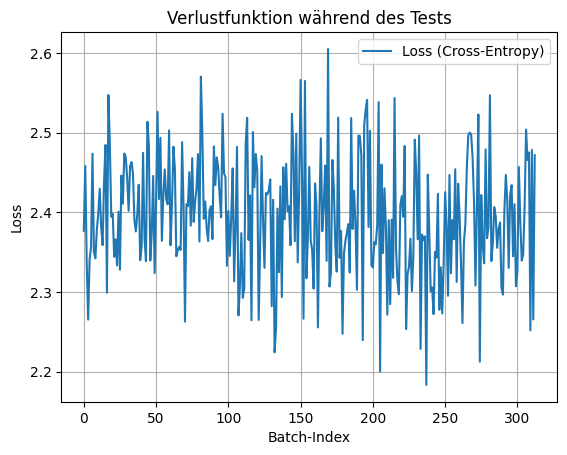

Accuracy (SNN): 10.00%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.00      0.00      0.00      1000
           2       0.00      0.00      0.00      1000
           3       0.00      0.00      0.00      1000
           4       0.00      0.00      0.00      1000
           5       0.00      0.00      0.00      1000
           6       0.00      0.00      0.00      1000
           7       0.00      0.00      0.00      1000
           8       0.00      0.00      0.00      1000
           9       0.10      1.00      0.18      1000

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000

F = 0.000, p = 1.000


In [13]:
from sklearn.metrics import classification_report
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import f_oneway

snn_model.eval()
correct = 0
total = 0
loss_values = []

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(images.size(0), -1).to(device)
        spikes = image_to_spikes(images, time_steps).to(device)

        outputs = snn_model(spikes)
        loss = snn_loss_fn(outputs, labels.to(device))
        loss_values.append(loss.item())

        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

        # Wichtig: Auf CPU bringen und zu Listen hinzufügen
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

plt.plot(loss_values, label="Loss (Cross-Entropy)")
plt.xlabel("Batch-Index")
plt.ylabel("Loss")
plt.title("Verlustfunktion während des Tests")
plt.legend()
plt.grid(True)
plt.show()
# Accuracy berechnen
accuracy = 100 * correct / total
print(f'Accuracy (SNN): {accuracy:.2f}%')

# Optional: target names, z. B. für KMNIST (0–9)
class_names = [str(i) for i in range(10)]

# Classification Report
report = classification_report(
    all_labels,
    all_preds,
    target_names=class_names,
    zero_division=0
)
print(report)

f_stat, p_val = f_oneway(all_labels, all_labels)
print(f"F = {f_stat:.3f}, p = {p_val:.3f}")


10. CNN Evaluieren

C:\Users\Ümmühan\AppData\Local\Temp\ipykernel_12508\3478100094.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


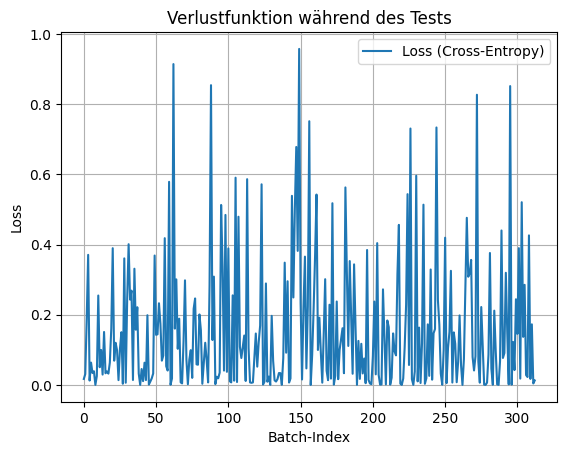

Accuracy (CNN): 96.62%
Precision (macro): 0.9663
Recall (macro):    0.9662
F1-Score (macro):  0.9661
F = 0.000, p = 1.000
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1000
           1       0.99      0.94      0.97      1000
           2       0.95      0.93      0.94      1000
           3       0.96      0.99      0.97      1000
           4       0.96      0.94      0.95      1000
           5       0.99      0.96      0.97      1000
           6       0.96      0.98      0.97      1000
           7       0.96      0.98      0.97      1000
           8       0.97      0.99      0.98      1000
           9       0.97      0.97      0.97      1000

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from matplotlib import pyplot as plt
from scipy.stats import f_oneway

loss_values = []
cnn_model.eval()
correct = 0
total = 0

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = cnn_model(images)
        loss = cnn_loss_fn(outputs, labels)
        loss_values.append(loss.item())
    
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Plot der Verlustkurve
plt.plot(loss_values, label="Loss (Cross-Entropy)")
plt.xlabel("Batch-Index")
plt.ylabel("Loss")
plt.title("Verlustfunktion während des Tests")
plt.legend()
plt.grid(True)
plt.show()

precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f'Accuracy (CNN): {100 * correct / total:.2f}%')
print(f'Precision (macro): {precision:.4f}')
print(f'Recall (macro):    {recall:.4f}')
print(f'F1-Score (macro):  {f1:.4f}')

f_stat, p_val = f_oneway(all_labels, all_labels)
print(f"F = {f_stat:.3f}, p = {p_val:.3f}")

report = classification_report(all_labels, all_preds, zero_division=0)
print(report)